In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from pclib.nn.models import PCLinearClassifier
from pclib.optim.train import train
from customdataset import PreloadedDataset
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
# ])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
# # shorten dataset
# length = 1000
# dataset = torch.utils.data.Subset(dataset, range(length))

VAL_RATIO = 0.0
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, transform, device)
# val_dataset = PreloadedDataset.from_dataset(val_dataset, transforms.ToTensor(), device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

In [4]:
seed = 42
torch.manual_seed(seed)
model_name = "mnist_pclinear"

# Model parameters
HIDDEN_DIMS = [2000, 2000, 2000]
SYMMETRIC = True
BIAS = True
STEPS = 20

model = PCLinearClassifier(INPUT_SHAPE, NUM_CLASSES, HIDDEN_DIMS, bias=BIAS, symmetric=SYMMETRIC, steps=STEPS).to(device)
step = 0
stats = None

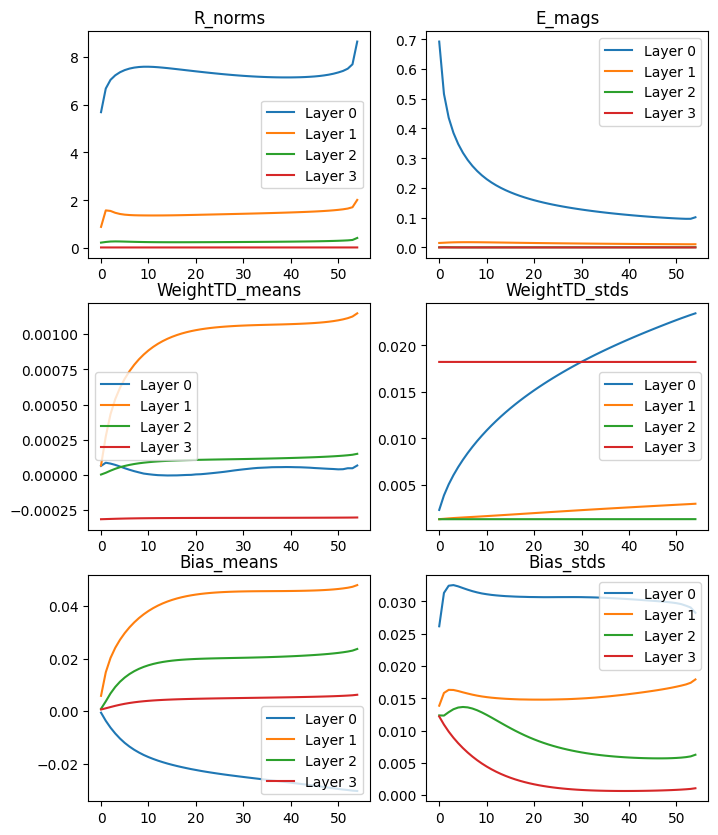

In [7]:
# Train Loop
LEARNING_RATE = 3e-4
NUM_EPOCHS = 90
BATCH_SIZE = 128
REG_COEFF = 10
step, stats = train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    LEARNING_RATE, 
    batch_size=BATCH_SIZE,
    reg_coeff=REG_COEFF,
    step=step, 
    stats=stats,
    device=device,
)
extra_rows = 0
height = 8
if not SYMMETRIC:
    extra_rows += 1
    height += 2 
if BIAS:
    extra_rows += 1
    height += 2
fig, axs = plt.subplots(2 + extra_rows, 2, figsize=(8, height))
for i in range(len(model.layers)):
    axs.flat[0].plot(stats['R_norms'][i], label=f"Layer {i}")
    axs.flat[1].plot(stats['E_mags'][i], label=f"Layer {i}")
    axs.flat[2].plot(stats['WeightTD_means'][i], label=f"Layer {i}")
    axs.flat[3].plot(stats['WeightTD_stds'][i], label=f"Layer {i}")
    idx = 4
    if not SYMMETRIC:
        axs.flat[idx].plot(stats['WeightBU_means'][i], label=f"Layer {i}")
        axs.flat[idx+1].plot(stats['WeightBU_stds'][i], label=f"Layer {i}")
        idx += 2
    if BIAS:
        axs.flat[idx].plot(stats['Bias_means'][i], label=f"Layer {i}")
        axs.flat[idx+1].plot(stats['Bias_stds'][i], label=f"Layer {i}")
        idx += 2



axs.flat[0].set_title(f"R_norms")
axs.flat[1].set_title(f"E_mags")
axs.flat[2].set_title(f"WeightTD_means")
axs.flat[3].set_title(f"WeightTD_stds")
axs.flat[0].legend()
axs.flat[1].legend()
axs.flat[2].legend()
axs.flat[3].legend()
idx = 4
if not SYMMETRIC:
    axs.flat[idx].set_title(f"WeightBU_means")
    axs.flat[idx+1].set_title(f"WeightBU_stds")
    axs.flat[idx].legend()
    axs.flat[idx+1].legend()
    idx += 2
if BIAS:
    axs.flat[idx].set_title(f"Bias_means")
    axs.flat[idx+1].set_title(f"Bias_stds")
    axs.flat[idx].legend()
    axs.flat[idx+1].legend()
    idx += 2
plt.show()

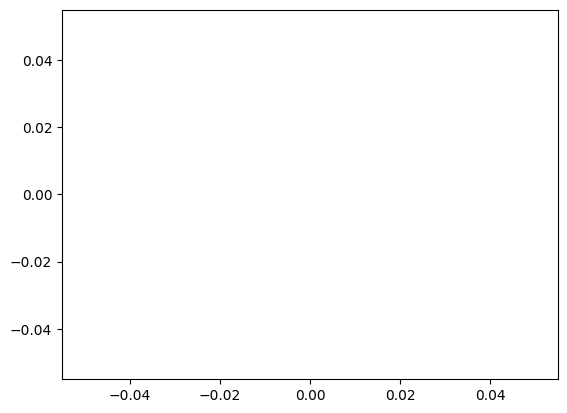

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
images, target = next(iter(train_loader))
x = images.flatten(start_dim=1).to(device)
y = torch.nn.functional.one_hot(target, NUM_CLASSES).float().to(device)

state = model.init_state(x.shape[0], mode='rand')
vfes = []
for step_i in range(3):
    with torch.no_grad():
        state = model.step(x, state, y)
        vfes.append(sum([state_i[1].square().mean() for state_i in state]).item())
    
plt.plot(vfes)

Max accuracy: 0.09871666666666666


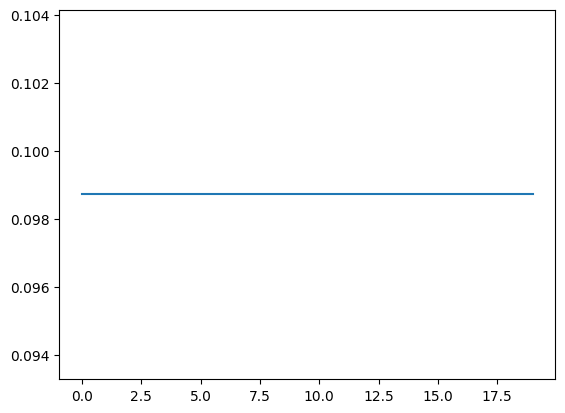

In [8]:
dataloader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=False)
t_steps = 20
correct = [0 for _ in range(t_steps)]
batch_size = 512
for x, y in dataloader:
    # print(f"\nData {idx}: {y}")
    bs = x.shape[0]
    x = x.flatten(start_dim=1).to(device)
    state = model.init_state(x.shape[0], mode='rand')

    for step_i in range(t_steps):
        with torch.no_grad():
            state = model.step(x, state)
        
        pred = state[-1][0].argmax(dim=1)
        correct[step_i] += (pred == y).sum().item()

acc = [c/len(dataset) for c in correct]
# print(acc)
plt.plot(acc)
print(f"Max accuracy: {max(acc)}")